# Pytorch Demo
This PyTorch demo is based around some of the ideas we encountered when looking at the browser-based TensorFlow playground: https://playground.tensorflow.org/

See https://pytorch.org/ for the extensive PyTorch documentation including how to get started, tutorials, recipies and link to the PyTorch YouTube series.

First we will import PyTorch.

In [1]:
import torch
import torch.nn as nn

If we have a GPU available, we'll use it. Otherwise we'll use the CPU.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

device

device(type='cuda')

Set the PyTorch random seed for reproducibility.

In [3]:
torch.manual_seed(42)

#### Functions to generate random 2D data points.
These functions generate the datasets that we can use to train our neural network. They are similar to the datasets available on TensorFlow Playground.

Similar to the 'Exclusive or' dataset from TensorFlow Playground.

In [4]:
def generate_xor_data(num_points, range_min=-6, range_max=6):
    """
    Generates a dataset that represents the XOR logic gate. Points from different quadrants 
    will belong to different classes, mimicking the non-linear separability of XOR.

    Args:
        num_points (int): Number of data points to generate.
        range_min (int): Minimum value of the range for generating data points.
        range_max (int): Maximum value of the range for generating data points.

    Returns:
        Tuple of (points, labels): where 'points' are the coordinates of the data points,
        and 'labels' are the corresponding binary class labels.
    """

    # Generate random points within the specified range
    points = (range_max - range_min) * torch.rand(num_points, 2) + range_min
    labels = torch.zeros(num_points, dtype=torch.float32)

    # Assign labels based on the XOR logic: opposite quadrants have different labels
    for i in range(num_points):
        if points[i,0] * points[i,1] < 0:  # i.e. if one and only one of the dimensions is negative
            labels[i] = 1.0
    return points, labels

This function generates data where it's possible to draw a straight line between both classes. It is similar to the 'Gaussian' dataset on TensorFlow Playground

In [5]:
def generate_linerarly_separable_data(num_points, range_min=-6, range_max=6):
    """
    Generates a set of linearly separable 2D data points. The separability is based on the sum of 
    the point coordinates. Points below the line x + y = 0 are labeled as one class, and above as another.

    Args:
        num_points (int): The number of data points to generate.
        range_min (int): The minimum value of the range for each coordinate.
        range_max (int): The maximum value of the range for each coordinate.

    Returns:
        points (Tensor): A tensor of shape (num_points, 2), where each row represents a point (x, y).
        labels (Tensor): A tensor of shape (num_points,), containing the label (0 or 1) for each point.
    """
    # Generate random points uniformly distributed within the specified range
    points = (range_max - range_min) * torch.rand(num_points, 2) + range_min
    labels = torch.zeros(num_points, dtype=torch.float32)

    # Label each point based on its position relative to the line x + y = 0
    for i in range(num_points):
        if points[i, 0] + points[i, 1] < 0:  # i.e. if the point is below the diagonal line x + y = 0
            labels[i] = 1.0
    return points, labels

This function generates a ring of points within another ring of points. It is similar to the 'Circle' dataset on TensorFlow Playground.

In [6]:
def generate_ring_data(num_points, inner_radius=1.5, outer_radius=5):
    """
    Generates a dataset with points distributed in two concentric rings. Points in the inner ring
    belong to one class, and points in the outer ring belong to another class.

    Args:
        num_points (int): Total number of data points to generate.
        inner_radius (float): Radius of the inner circle defining the first class.
        outer_radius (float): Radius of the outer circle defining the second class.

    Returns:
        points (Tensor): A tensor of shape (num_points, 2), each row represents a point (x, y).
        labels (Tensor): A tensor of shape (num_points,), containing the label (0 or 1) for each point.
    """
    # Initialize tensors for points and labels
    points = torch.zeros(num_points, 2)
    labels = torch.zeros(num_points, dtype=torch.float32)

    # Half the points go into the inner circle, half into the outer
    for i in range(num_points):
        angle = torch.rand(1) * 2 * torch.pi  # Random angle
        if i < num_points // 2:
            # Random radius in the inner ring
            radius = torch.rand(1) * (inner_radius - 0.5) + 0.5
            labels[i] = 1.0  # Class 1 for inner ring
        else:
            # Random radius in the outer ring (with a padding of 1 between inner and outer rings)
            radius = torch.rand(1) * (outer_radius -
                                      inner_radius - 1) + inner_radius + 1
            labels[i] = 0.0  # Class 0 for outer ring

        # Convert polar coordinates to Cartesian coordinates
        points[i, 0] = radius * torch.cos(angle)  # x coordinate
        points[i, 1] = radius * torch.sin(angle)  # y coordinate

    return points, labels

This function generates data similar to the 'Spiral' dataset on TensorFlow Playground. This function is a Python/PyTorch port of the actual TensorFlow Playground code, specifically the classifySpiralData function written in TypeScript and available on Github: https://github.com/tensorflow/playground/blob/master/src/dataset.ts

In [7]:
def generate_spiral_data(num_samples, noise=0.1):
    """
    Generates a 2D spiral dataset suitable for classification tasks.
    
    Args:
        num_samples (int): Total number of samples to generate. Should be an even number.
        noise (float): Amount of noise to add to the data points. Higher values add more noise.

    Returns:
        torch.Tensor: A tensor of shape (num_samples, 3), where each row represents a point
                      (x, y, label). 'label' is 1 for positive class and 0 for negative class.
    
    The dataset consists of two interleaved spirals with labels 1 and 0 respectively. Noise is added
    to the points to make the classification task non-trivial.
    """
    assert num_samples % 2 == 0  # Make sure num_samples is even

    points = torch.zeros((num_samples, 2))
    labels = torch.zeros(num_samples)
    n = num_samples // 2

    def gen_spiral(delta_t, label, start_idx):
        """
        Generates a single spiral.

        Args:
            delta_t (float): Phase shift for generating the second spiral. In a spiral, points are
                             distributed around a central point with a certain angular displacement.
                             By adding a phase shift (delta_t), we can generate a second spiral that
                             is interleaved with the first one. In the function, delta_t is set to 0
                             for the first spiral and to π (pi) for the second spiral, ensuring that
                             the two spirals are offset by half a rotation, thus intertwining them.
            label (int) : The label (0 or 1) for this spiral.
            start_idx (int): An offset to ensure that the second spiral doesn't overwrite th points
                             and labels of the first spiral. 
        """
        for i in range(n):
            # Radius of the spiral at a particular point: r determines how far a point is from the centre
            # of the spiral. It is calculated as i / n * 5, where i is the index of the point and n is
            # half the total number of samples (since each spiral contains half of the points). This
            # ensures that r increases linearly from 0 to 5 as i goes from 0 to n, causing points to
            # spiral outward from the center.
            r = torch.tensor(i / n * 5)

            # Angle for the current point in the spiral: t determines the angular position of the point
            # around the center of the spiral. It is calculated as 1.75 * i / n * 2 * π + delta_t. The
            # term 1.75 * i / n * 2 * π creates a spiral that makes approximately 1.75 full turns as i
            # goes from 0 to n. Adding delta_t shifts the phase of the spiral to create the second
            # interleaved spiral.
            t = torch.tensor(1.75 * i / n * 2 * torch.pi + delta_t)
            
            x = r * torch.sin(t) + (torch.rand(1) * 2 - 1) * noise
            y = r * torch.cos(t) + (torch.rand(1) * 2 - 1) * noise
            points[start_idx + i, 0] = x
            points[start_idx + i, 1] = y
            labels[start_idx + i] = label

    gen_spiral(0, 1, 0)         # Positive examples
    gen_spiral(torch.pi, 0, n)  # Negative examples (the original function used -1 as label rather than 0)
    return points, labels

## Generate the data
We can easily vary the dataset by choosing one of the data generation functions.

In [8]:
TRAINING_SET_SIZE = 300
TEST_SET_SIZE = 70

data_generator = generate_xor_data
#data_generator = generate_linerarly_separable_data
#data_generator = generate_ring_data
#data_generator = generate_spiral_data

train_data, train_labels = data_generator(TRAINING_SET_SIZE)
test_data, test_labels = data_generator(TEST_SET_SIZE)

In [9]:
train_data

tensor([[ 4.5872,  4.9800],
        [-1.4056,  5.5117],
        [-1.3146,  1.2107],
        [-2.9211,  3.5237],
        [ 5.2893, -4.4018],
        [ 5.2152,  1.1230],
        [ 4.4329,  0.8126],
        [ 2.8931, -0.8471],
        [ 4.6253,  0.8869],
        [-2.8010,  1.5294],
        [-2.7644, -0.7036],
        [-2.4369,  3.9802],
        [-4.7362, -2.7661],
        [-1.6942, -3.6076],
        [ 0.5663, -5.9261],
        [ 5.4187, -5.0968],
        [ 4.6322,  0.9985],
        [-1.9482,  3.7077],
        [ 0.9351,  4.8478],
        [ 0.6559, -1.8922],
        [ 1.6121, -1.6271],
        [ 2.5251,  5.3569],
        [ 3.4684, -2.6230],
        [ 3.4636,  1.0736],
        [ 3.0470, -3.6570],
        [-5.9395, -2.3182],
        [-4.6021,  4.9232],
        [ 1.7282,  2.4853],
        [ 1.8976, -0.1044],
        [ 4.6957, -4.2631],
        [ 0.3778, -4.0952],
        [ 1.8501, -2.0663],
        [ 1.8385, -1.2500],
        [ 4.9764, -3.5562],
        [-3.5784, -3.5786],
        [ 5.3967,  1

In [10]:
train_labels

tensor([0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
        0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
        1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
        0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.,
        1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
        0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1.,
        1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1.,
        0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

Let's visualize our training data. We'll use Seaborn with a little help from Pandas.

In [11]:
import pandas as pd
import seaborn as sns

<Axes: xlabel='X1', ylabel='X2'>

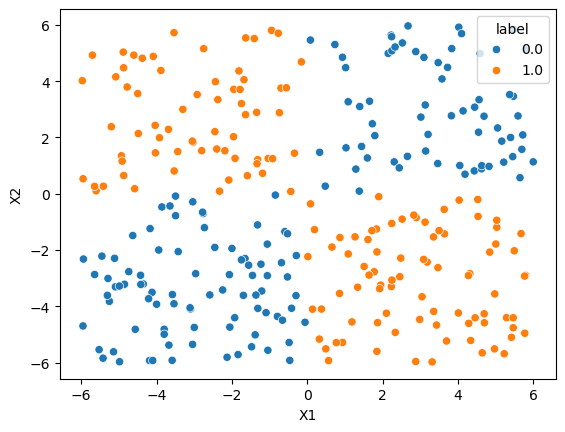

In [12]:
training_df = pd.DataFrame()
training_df['X1'] = train_data[:, 0]
training_df['X2'] = train_data[:, 1]
training_df['label'] = train_labels


sns.scatterplot(data=training_df,
                x="X1",
                y="X2",
                hue="label")

## Neural network architecture

In [13]:
N_INPUT_NEURONS = 2              # Input layer
N_NEURONS_IN_HIDDEN_LAYER_1 = 4  # First hidden layer
N_NEURONS_IN_HIDDEN_LAYER_2 = 2  # Second hidden layer
N_OUTPUT_NEURONS = 1             # Output layer

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()

        # You can experiment with different activation functions. E.g.:
        # self.activation = nn.ReLU()
        self.activation_function = nn.Tanh()
        
        # Define a simple neural network architecture.
        # We will use fully-connected 'nn.Linear' layers to transform input to output.
        self.net = nn.Sequential(
            # Connect all input neurons to all hidden layer 1 neurons
            nn.Linear(N_INPUT_NEURONS, N_NEURONS_IN_HIDDEN_LAYER_1),
            self.activation_function,

            # Connect all hidden layer 1 neurons to all hidden layer 2 neurons
            nn.Linear(N_NEURONS_IN_HIDDEN_LAYER_1, N_NEURONS_IN_HIDDEN_LAYER_2),
            self.activation_function,

            # Connect all hidden layer 2 neurons to the output neuron
            nn.Linear(N_NEURONS_IN_HIDDEN_LAYER_2, N_OUTPUT_NEURONS),
            # Use the sigmoid activation function for the output node since we have
            # a binary classification task and sigmoid outputs over the range 0 to 1.
            nn.Sigmoid()
        )


    def forward(self, inputs):
        """
        Forward pass of the neural network.
        Args:
            x (tensor): Input data.
        Returns:
            Output tensor after passing through the network.
        """
        return self.net(inputs)

## Training procedure

In [14]:
def train(model, loss_function, optimizer, data, labels, epochs):
    """
    Trains the neural network model.

    Args:
        model: The neural network model to train.
        loss_function: Loss function to minimize.
        optimizer: Optimization algorithm.
        data: Input data for training.
        labels: Correct labels for the training data.
        epochs: Number of times to iterate over the training dataset.
    """
    for epoch in range(epochs):
        optimizer.zero_grad()  # Reset gradients to zero for each epoch
        outputs = model(data)  # Compute model output
        loss = loss_function(outputs, labels.view(-1, 1))  # Calculate loss
        loss.backward()  # Compute gradient of the loss w.r.t. network parameters
        optimizer.step()  # Update parameters

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

## Choose a loss function

There are many loss functions available in PyTorch (https://pytorch.org/docs/stable/nn.html#loss-functions), the most popular include:
- CrossEntropyLoss: Extremely popular for multi-class classification problems.
- MSELoss: Widely used in regression tasks.
- BCELoss / BCEWithLogitsLoss: Commonly used for binary classification tasks.
- L1Loss: Frequently used in regression when robustness to outliers is needed.
- SmoothL1Loss: Popular in computer vision tasks, particularly object detection.
- TripletMarginLoss: Used in metric learning tasks like face recognition.

In this case we have a binary classification task, so we'll choose BCELoss. 

In [15]:
loss_function = nn.BCELoss()

## Initialize the model and optimizer

PyTorch also has a number of optimization algorithms (https://pytorch.org/docs/stable/optim.html). The most popular include:
- SGD: A machine learning staple, particularly popular for its simplicity and effectiveness in large-scale learning problems.
- Adam: One of the most popular optimizers, especially for deep learning tasks, due to its adaptive learning rate and momentum.
- AdamW: Increasingly popular in deep learning, particularly with transformer models.
- RMSprop: Frequently used for training recurrent neural networks, valued for its adaptive learning rate.
- Adagrad: Widely used in natural language processing and other tasks with sparse data.

In [ ]:
# The default learning rate is 0.001, but we can experiment.
learning_rate = 0.03

# Create an instance of the NeuralNetwork we defined.
model = NeuralNet()

# Use the popuar Adam optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [17]:
def print_weights_and_biases(model):
    """
    Prints the weights and biases of a PyTorch model. This function assumes that the model's
    parameters are organized into named layers and that each layer's parameters require gradients,
    which is typical for trainable parameters in neural networks.

    Args:
        model (nn.Module): The PyTorch model from which weights and biases are to be printed.

    This function iterates through all named parameters of the model, checking if they require
    gradients (a common indicator that the parameter is trainable and used during model training).
    It prints both the name of the parameter and its current values.
    """
    # Iterate over all named parameters in the model
    for name, param in model.named_parameters():
        # Check if the parameter requires gradients
        if param.requires_grad:
            print(f"{name}:")
            print(param.data)  # Print the parameter values

In [18]:
print_weights_and_biases(model)

net.0.weight:
tensor([[ 0.4231,  0.1108],
        [ 0.2330,  0.6711],
        [-0.4562, -0.3210],
        [ 0.4946, -0.4838]])
net.0.bias:
tensor([-0.3899,  0.5162,  0.2231,  0.2284])
net.2.weight:
tensor([[-0.2119, -0.0069,  0.4576, -0.3001],
        [ 0.0039,  0.2378, -0.3452,  0.4856]])
net.2.bias:
tensor([-0.2498, -0.1201])
net.4.weight:
tensor([[-0.1913, -0.4608]])
net.4.bias:
tensor([-0.6939])


We can also examine the general structure of the model.

In [19]:
model

NeuralNet(
  (activation_function): Tanh()
  (net): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=2, bias=True)
    (3): Tanh()
    (4): Linear(in_features=2, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

Move tensors to GPU if we have one available.

In [20]:
if device != 'cpu':
    train_data = train_data.to(device)
    train_labels = train_labels.to(device)
    test_data = test_data.to(device)
    test_labels = test_labels.to(device)
    model = model.to(device)

## Train the model

In [21]:
n_epochs = 100

train(model,
      loss_function,
      optimizer,
      train_data,
      train_labels,
      epochs=n_epochs)

Epoch 10/100, Loss: 0.7325335741043091
Epoch 20/100, Loss: 0.7254837155342102
Epoch 30/100, Loss: 0.7193663120269775
Epoch 40/100, Loss: 0.714046061038971
Epoch 50/100, Loss: 0.7094049453735352
Epoch 60/100, Loss: 0.705339789390564
Epoch 70/100, Loss: 0.7017611861228943
Epoch 80/100, Loss: 0.6985913515090942
Epoch 90/100, Loss: 0.6957628726959229
Epoch 100/100, Loss: 0.6932175159454346


We can see now that the weights and biases have changed as a result of training.

In [22]:
print_weights_and_biases(model)

net.0.weight:
tensor([[ 0.4366,  0.0907],
        [ 0.1919,  0.6988],
        [-0.3913, -0.3803],
        [ 0.5023, -0.4753]], device='cuda:0')
net.0.bias:
tensor([-0.3766,  0.4947,  0.2516,  0.2517], device='cuda:0')
net.2.weight:
tensor([[-0.2207, -0.0589,  0.4650, -0.2850],
        [-0.0134,  0.2255, -0.3598,  0.4518]], device='cuda:0')
net.2.bias:
tensor([-0.3061, -0.2579], device='cuda:0')
net.4.weight:
tensor([[-0.2775, -0.4850]], device='cuda:0')
net.4.bias:
tensor([-0.4010], device='cuda:0')


## Test the model

In [23]:
# Set the model to evaluation mode as opposed to training mode. This is necessary in general because
# some model layers behave differently during training than during inference, such as dropout layers
# and batch normalization layers.
model.eval()

# disable gradient calculation, which is unnecessary during inference
with torch.no_grad():
    # The output layer of the network consists of a single neuron that uses a sigmoid activation function.
    # This will output values between 0 and 1. We check whether this value is >= 0.5, if so we assume it
    # refers to class 1, otherwise class 0.
    predictions = model(test_data).view(-1) >= 0.5

    accuracy = (predictions.float() == test_labels).float().mean().item()
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 57.14%


In [24]:
predictions.float()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

In [25]:
# Here the accuracy calculation is repeated so that we can break it down.
(predictions.float() == test_labels).float().mean().item()

0.5714285969734192

In [26]:
model(test_data)

tensor([[0.4461],
        [0.4605],
        [0.4361],
        [0.4592],
        [0.4266],
        [0.4460],
        [0.4439],
        [0.3977],
        [0.4423],
        [0.4434],
        [0.4499],
        [0.4591],
        [0.4393],
        [0.4471],
        [0.4500],
        [0.4574],
        [0.4463],
        [0.4453],
        [0.4600],
        [0.4603],
        [0.4439],
        [0.3896],
        [0.4604],
        [0.4192],
        [0.4401],
        [0.4330],
        [0.3860],
        [0.4516],
        [0.4389],
        [0.4469],
        [0.4504],
        [0.4461],
        [0.3964],
        [0.3951],
        [0.4552],
        [0.4475],
        [0.3856],
        [0.4449],
        [0.4483],
        [0.4600],
        [0.3864],
        [0.4478],
        [0.4438],
        [0.4604],
        [0.4605],
        [0.4550],
        [0.4550],
        [0.4431],
        [0.4069],
        [0.4429],
        [0.4357],
        [0.4382],
        [0.4465],
        [0.3981],
        [0.4499],
        [0

## Visualize the decision boundary of the trained model

In [27]:
import matplotlib.pyplot as plt
import numpy as np

In [28]:
def plot_decision_boundary(model, data, labels):
    """
    Plots the decision boundary created by a neural network model along with the data points.

    Args:
        model: The trained neural network model.
        data (tensor): The input data as a PyTorch tensor.
        labels (tensor): The labels corresponding to the input data.

    This function converts the PyTorch tensors to NumPy arrays, generates a meshgrid to represent the space,
    predicts the model's outputs over this grid to determine where the decision boundary lies, and plots
    the results using a contour plot alongside the original training examples.
    """
    # Convert the data from PyTorch tensors to NumPy arrays for plotting
    data_np = data.numpy()
    labels_np = labels.numpy()
    
    # Define the range for the grid that will represent the decision surface
    # Expand the range slightly beyond the min and max values to ensure all data points are well-contained within the plot
    x_min, x_max = data_np[:, 0].min() - 1, data_np[:, 0].max() + 1
    y_min, y_max = data_np[:, 1].min() - 1, data_np[:, 1].max() + 1

    # Create a meshgrid which will be used for plotting the decision boundary
    # np.arange creates a vector of values from x_min to x_max with a step size of 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1),
                         indexing='ij')
    
    # Predicting over the meshgrid
    # Flatten the grid so the model can classify every point in the space
    grid = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()

    # Predict the function output for all points in the grid without tracking gradients
    with torch.no_grad():
        preds = model(grid).view(xx.shape) >= 0.5
    
    # Convert predictions back to a NumPy array for plotting
    preds_np = preds.numpy()
    
    # Create a contour plot to show the decision boundary
    # contourf fills between the regions, alpha controls transparency, and levels set the threshold for classification
    plt.contourf(xx,
                 yy,
                 preds_np,
                 alpha=0.5,
                 levels=[-0.5, 0.5, 1.5],
                 colors=['red', 'blue']
                 )

    # Scatter plot of the actual data points; color-coded by their labels
    plt.scatter(x=data_np[:, 0],
                y=data_np[:, 1],
                c=labels_np,
                cmap=plt.cm.RdYlBu,
                edgecolors='k')

    # Label the axes and the plot
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Decision Boundary and Training Data')
    plt.show()

Move the training data and model back to CPU if necessary.

In [29]:
if device != 'cpu':
    train_data = train_data.to('cpu')
    train_labels = train_labels.to('cpu')
    model = model.to('cpu')

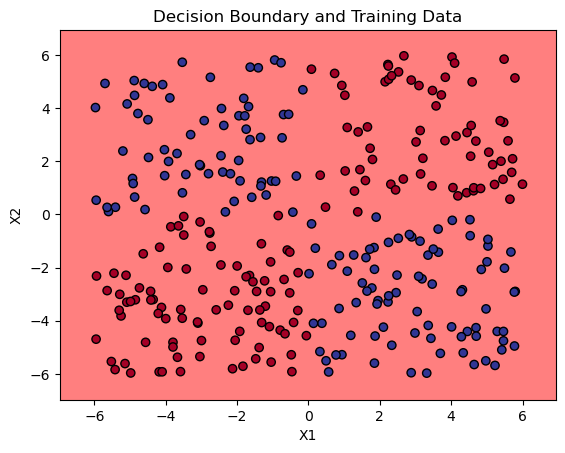

In [30]:
plot_decision_boundary(model, train_data, train_labels)

# Challenge
The demo PyTorch neural network doesn't train very well on the concentric rings dataset, and does a poor job on the spiral dataset. Experiment with the code to produce better models. You can change any of the hyperparameters including the learning rate, number of layers, number of neurons in a given layer, and choice of activation function. You can also change the number of training epochs, configure the optimizer differently or use a different optimizer. You might like to try out ideas using TensorFlow Playground where it's easier to experiment with the network topology and other options. You can then implement any promising ideas in code.